# Model Experimentation

### Table of Contents

1. [Import Packages and Data](#import)     


**Objective:**

The main objective of this notebook is to experiment with different regression models using the split dataset - `train.csv` and `test.csv` to generate baseline models results.

**Description**

In this experiment, we have chosen a variety of regression models from linear models to tree-based and ensemble models. Here are the following regression models:

1. Linear Regression
2. Decision Tree Regressor
3. Random Forest Regressor
4. XGBoost Regressor
5. LightGBM Regressor
6. Explainable Boosting Regressor

## 1. Import Packages and Data<a class="anchor" id="import"></a>

**Import Packages:**

In [43]:

import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

sys.path.append("..")

from src.utils.modelling.modelling import (
    clean_column_names, evaluate_model, get_cross_val_scores
)

**Import Data:**

In [44]:
train_data = pd.read_csv("../data/split/train.csv")
test_data = pd.read_csv("../data/split/test.csv")

## 2. Splitting Data & Setting Up KFold:<a class="anchor" id="data"></a>

**Define target column:**

In [45]:
target_column = '2020energyuseintensity'

**Set up `X_train`, `y_train`, `X_test` and `X_test`:**

In [46]:
X_train = train_data.drop(columns=[target_column])
y_train = train_data[target_column]

X_test = test_data.drop(columns=[target_column])
y_test = test_data[target_column]

**Set up `KFold`:**

For the intial modelling, we will start off with n_splits of 5.

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## 3. Model - Linear Regression<a class="anchor" id="lr"></a>

**Instantiate Model:**

In [48]:
lr = LinearRegression()

**Perform cross-validation:**

In [49]:
get_cross_val_scores(
    model=lr, 
    X_train=X_train, 
    y_train=y_train, 
    cross_validator=kf, 
    scoring_metrics=[
        'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'
    ]
)

INFO:root:Cross Validation Results:


Test neg_mean_absolute_error: 31.51 EUI
Train neg_mean_absolute_error: 27.53 EUI
Test neg_root_mean_squared_error: 63.05 EUI
Train neg_root_mean_squared_error: 55.29 EUI
Test r2: 0.88
Train r2: 0.91


**Evaluate model:**

In [50]:
lr.fit(X_train, y_train)
evaluate_model(model=lr, X_test=X_test, y_test=y_test)

INFO:root:Evaluation results:



MAE: 32.18
MSE: 3933.09
RMSE: 62.71
R-squared: 0.83


## 4. Model - Decision Tree Regressor<a class="anchor" id="dtr"></a>

**Instantiate Model:**

In [51]:
dtr = DecisionTreeRegressor()

**Perform cross-validation:**

In [52]:
get_cross_val_scores(
    model=dtr, 
    X_train=X_train, 
    y_train=y_train, 
    cross_validator=kf, 
    scoring_metrics=[
        'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'
    ]
)

INFO:root:Cross Validation Results:


Test neg_mean_absolute_error: 46.79 EUI
Train neg_mean_absolute_error: 0.00 EUI
Test neg_root_mean_squared_error: 109.01 EUI
Train neg_root_mean_squared_error: 0.00 EUI
Test r2: 0.66
Train r2: 1.00


**Evaluate model:**

In [53]:
dtr.fit(X_train, y_train)
evaluate_model(model=dtr, X_test=X_test, y_test=y_test)

INFO:root:Evaluation results:



MAE: 45.61
MSE: 6790.75
RMSE: 82.41
R-squared: 0.71


## 5. Model - Random Forest Regressor<a class="anchor" id="rfr"></a>

**Instantiate Model:**

In [54]:
rfr = RandomForestRegressor()

**Perform cross-validation:**

In [55]:
get_cross_val_scores(
    model=rfr, 
    X_train=X_train, 
    y_train=y_train, 
    cross_validator=kf, 
    scoring_metrics=[
        'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'
    ]
)

INFO:root:Cross Validation Results:


Test neg_mean_absolute_error: 31.99 EUI
Train neg_mean_absolute_error: 12.15 EUI
Test neg_root_mean_squared_error: 74.56 EUI
Train neg_root_mean_squared_error: 28.84 EUI
Test r2: 0.84
Train r2: 0.98


**Evaluate model:**

In [56]:
rfr.fit(X_train, y_train)
evaluate_model(model=rfr, X_test=X_test, y_test=y_test)

INFO:root:Evaluation results:



MAE: 30.46
MSE: 3381.56
RMSE: 58.15
R-squared: 0.85


**Compute Permutation Importance:**

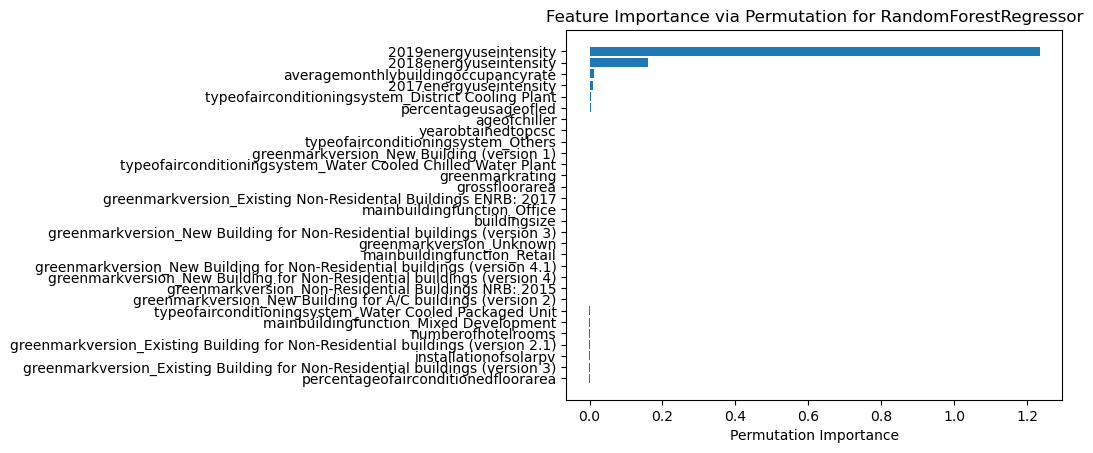

In [57]:
perm_importance = permutation_importance(
    rfr, X_test, y_test, n_repeats=30, random_state=42
)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation for RandomForestRegressor")
plt.show()

**Retrain Model using selected features:**

In [58]:
perm_importance_mean = perm_importance.importances_mean
threshold = 0.01 * np.max(perm_importance_mean)
important_features_idx = np.where(perm_importance_mean > threshold)[0]
X_train_selected = X_train.iloc[:, important_features_idx]
X_test_selected = X_test.iloc[:, important_features_idx]

In [59]:
get_cross_val_scores(
    model=rfr, 
    X_train=X_train_selected, 
    y_train=y_train, 
    cross_validator=kf, 
    scoring_metrics=[
        'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'
    ]
)

INFO:root:Cross Validation Results:


Test neg_mean_absolute_error: 32.11 EUI
Train neg_mean_absolute_error: 12.04 EUI
Test neg_root_mean_squared_error: 69.95 EUI
Train neg_root_mean_squared_error: 27.60 EUI
Test r2: 0.86
Train r2: 0.98


In [60]:
rfr.fit(X_train_selected, y_train)
evaluate_model(model=rfr, X_test=X_test_selected, y_test=y_test)

INFO:root:Evaluation results:



MAE: 31.43
MSE: 3263.38
RMSE: 57.13
R-squared: 0.86


## 6. Model - XGBoost Regressor<a class="anchor" id="xgbr"></a>

**Instantiate Model:**

In [61]:
xgbr = XGBRegressor()

In [94]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 30 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   buildingsize                                                                    451 non-null    int64  
 1   yearobtainedtopcsc                                                              451 non-null    int64  
 2   greenmarkrating                                                                 451 non-null    int64  
 3   grossfloorarea                                                                  451 non-null    float64
 4   percentageofairconditionedfloorarea                                             451 non-null    float64
 5   averagemonthlybuildingoccupancyrate                                             451 non-null    float64
 6   numberofhotelrooms

**Perform cross-validation:**

In [91]:
get_cross_val_scores(
    model=xgbr, 
    X_train=X_train, 
    y_train=y_train, 
    cross_validator=kf, 
    scoring_metrics=[
        'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'
    ]
)

INFO:root:Cross Validation Results:


Test neg_mean_absolute_error: 34.89 EUI
Train neg_mean_absolute_error: 0.14 EUI
Test neg_root_mean_squared_error: 76.60 EUI
Train neg_root_mean_squared_error: 0.20 EUI
Test r2: 0.83
Train r2: 1.00


**Evaluate model:**

In [92]:
xgbr.fit(X_train, y_train)
evaluate_model(model=xgbr, X_test=X_test, y_test=y_test)

INFO:root:Evaluation results:



MAE: 34.34
MSE: 3552.60
RMSE: 59.60
R-squared: 0.85


**Plot importance for XGBoost Regressor - Weight:**

`"weight"`: Number of times a feature appears in a tree across all trees.

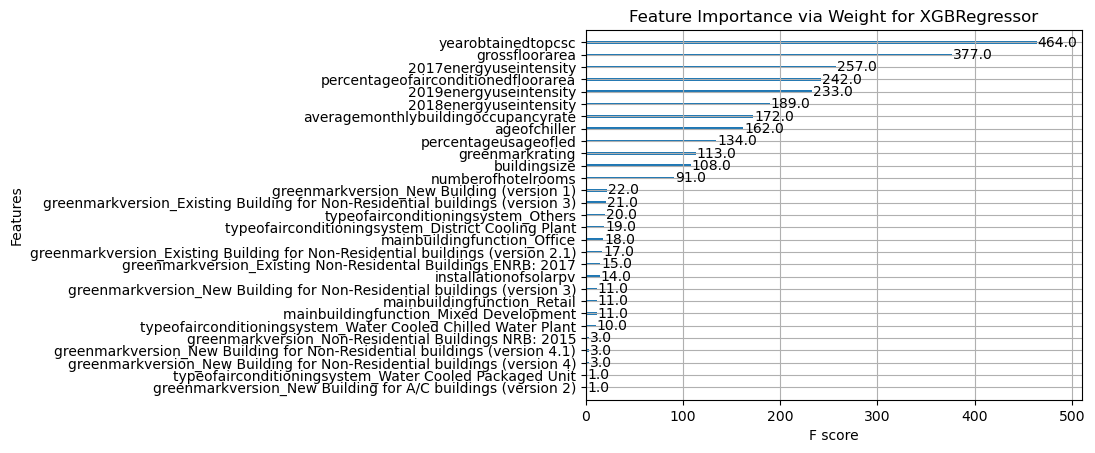

In [64]:
xgb.plot_importance(xgbr, importance_type="weight", title="Feature Importance via Weight for XGBRegressor")
plt.show()

**Plot importance for XGBoost Regressor - Gain:**

`"gain"`: Average gain of a feature when it's used in trees.

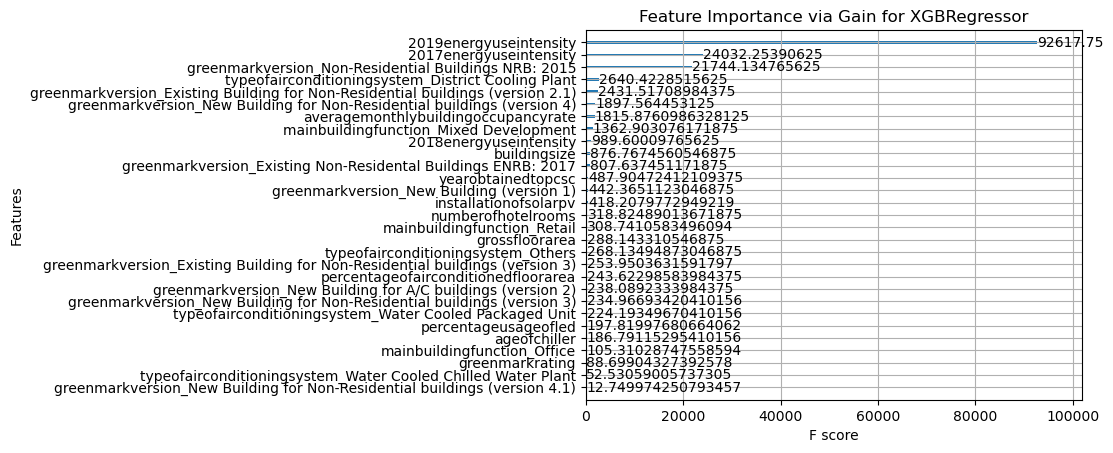

In [65]:
xgb.plot_importance(xgbr, importance_type="gain", title="Feature Importance via Gain for XGBRegressor")
plt.show()

**Retrain Model using selected features:**

In [66]:
importances = xgbr.get_booster().get_score(importance_type='gain')
importance_values = [importances.get(feat, 0.) for feat in X_train.columns]
threshold = 0.01 * np.max(list(importances.values()))
important_features_idx = [
    i for i, imp in enumerate(importance_values) if imp > threshold
]
X_train_selected = X_train.iloc[:, important_features_idx]
X_test_selected = X_test.iloc[:, important_features_idx]

In [67]:
get_cross_val_scores(
    model=xgbr, 
    X_train=X_train_selected, 
    y_train=y_train, 
    cross_validator=kf, 
    scoring_metrics=[
        'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'
    ]
)

INFO:root:Cross Validation Results:


Test neg_mean_absolute_error: 34.87 EUI
Train neg_mean_absolute_error: 0.99 EUI
Test neg_root_mean_squared_error: 71.14 EUI
Train neg_root_mean_squared_error: 1.47 EUI
Test r2: 0.85
Train r2: 1.00


In [68]:
xgbr.fit(X_train_selected, y_train)
evaluate_model(model=xgbr, X_test=X_test_selected, y_test=y_test)

INFO:root:Evaluation results:



MAE: 35.28
MSE: 3895.28
RMSE: 62.41
R-squared: 0.83


## 7. Model - LightGBM Regressor<a class="anchor" id="lgbmr"></a>

**Instantiate Model:**

In [69]:
lgbr = LGBMRegressor()

**Preprocessing to remove special characters in feature names:**

In [70]:
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

**Perform cross-validation:**

In [71]:
get_cross_val_scores(
    model=lgbr, 
    X_train=X_train, 
    y_train=y_train, 
    cross_validator=kf, 
    scoring_metrics=[
        'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 360, number of used features: 21
[LightGBM] [Info] Start training from score 235.079333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

INFO:root:Cross Validation Results:


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

**Evaluate model:**

In [72]:
lgbr.fit(X_train, y_train)
evaluate_model(model=lgbr, X_test=X_test, y_test=y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 451, number of used features: 22
[LightGBM] [Info] Start training from score 234.040554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

INFO:root:Evaluation results:



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## 8. Model - Explainable Boosting Regressor<a class="anchor" id="ebmr"></a>

**Instantiate Model:**

In [73]:
ebmr = ExplainableBoostingRegressor()

**Perform cross-validation:**

In [74]:
get_cross_val_scores(
    model=ebmr, 
    X_train=X_train, 
    y_train=y_train, 
    cross_validator=kf, 
    scoring_metrics=[
        'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'
    ]
)

INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._ebm:Estimating with FAST
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._

Test neg_mean_absolute_error: 43.96 EUI
Train neg_mean_absolute_error: 22.08 EUI
Test neg_root_mean_squared_error: 87.60 EUI
Train neg_root_mean_squared_error: 38.65 EUI
Test r2: 0.78
Train r2: 0.96


**Evaluate model:**

In [75]:
ebmr.fit(X_train, y_train)
evaluate_model(model=ebmr, X_test=X_test, y_test=y_test)

INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._ebm:Estimating with FAST
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:root:Evaluation results:



MAE: 43.89
MSE: 5171.42
RMSE: 71.91
R-squared: 0.78


**Analyse Global Feature Importance:**

In [76]:
ebm_global = ebmr.explain_global()
show(ebm_global)

INFO:interpret.visual._udash:Generating mini dash
INFO:interpret.visual._udash:Generated mini dash


<!-- http://127.0.0.1:7001/6412129616/ -->

In [77]:
ebm_local = ebmr.explain_local(X_test, y_test)
show(ebm_local)

INFO:interpret.utils._unify_data:Unifying data
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.visual._udash:Generating mini dash
INFO:interpret.visual._udash:Generated mini dash


<!-- http://127.0.0.1:7001/6305933072/ -->

INFO:interpret.visual._udash:No overall plot to display: -1|ExplainableBoostingRegressor_3


In [80]:
features = ebm_global._internal_obj['overall']
feature_names = features['names']
feature_importances = features['scores']
univariate_features = [name for name in feature_names if '&' not in name]
univariate_importances = [
    feature_importances[feature_names.index(name)] for name in univariate_features
]

importance_df = pd.DataFrame({
    'Feature': univariate_features,
    'Importance': univariate_importances
})
importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
12,2019energyuseintensity,32.707748
11,2018energyuseintensity,27.638713
10,2017energyuseintensity,27.060859
5,averagemonthlybuildingoccupancyrate,8.593690
14,mainbuildingfunction_Office,7.282751
4,percentageofairconditionedfloorarea,7.212450
15,mainbuildingfunction_Retail,6.665386
1,yearobtainedtopcsc,6.155818
8,percentageusageofled,5.202521
2,greenmarkrating,4.515943


In [84]:
threshold = importance_df['Importance'].mean()
# threshold = 1.00
selected_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [85]:
get_cross_val_scores(
    model=ebmr, 
    X_train=X_train_selected, 
    y_train=y_train, 
    cross_validator=kf, 
    scoring_metrics=[
        'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'
    ]
)

INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._ebm:Estimating with FAST
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._

Test neg_mean_absolute_error: 40.68 EUI
Train neg_mean_absolute_error: 27.13 EUI
Test neg_root_mean_squared_error: 83.48 EUI
Train neg_root_mean_squared_error: 49.47 EUI
Test r2: 0.80
Train r2: 0.93


In [86]:
ebmr.fit(X_train_selected, y_train)
evaluate_model(model=ebmr, X_test=X_test_selected, y_test=y_test)

INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.utils._compressed_dataset:Creating native dataset
INFO:interpret.glassbox._ebm._ebm:Estimating with FAST
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:interpret.glassbox._ebm._bin:eval_terms
INFO:root:Evaluation results:



MAE: 41.35
MSE: 4624.20
RMSE: 68.00
R-squared: 0.80


## 9. Summary and Conclusion<a class="anchor" id="summary"></a>

<div style="background-color: black; color: white; padding: 10px">
    <p> Based on the experimentations, we will focus the results reporting with the three best performing models - `Random Forest Regressor`, `XGBoost Regressor` and `EBM Regressor`. To determine the best model based on the provided scores, we'll consider the following criteria:

1. Performance on the Test Set: This is the most crucial metric, as the test set performance indicates how the model will likely perform on unseen data.
2. Overfitting: Ideally, there should not be a large difference between training and testing scores. A huge gap may indicate that the model is overfitting.
3. Evaluation Metrics: We'll focus on RMSE, R-squared, and MAE. Lower RMSE and MAE are better, while higher R-squared indicates a better fit of the model to the data.


**Based on the provided scores:**

1. Random Forest (RF) Regressor:
    - Test RMSE: 58.15 EUI
    - R-squared: 0.85
    - Test MAE: 30.46 EUI
    - Gap between Train and Test RMSE: 28.84 - 58.15 = -29.31 (indicating some overfitting)
<br>
2. XGBoost Regressor:

    - Test RMSE: 59.60 EUI
    - R-squared: 0.85
    - Test MAE: 34.34 EUI
    - Gap between Train and Test RMSE: 0.20 - 59.60 = -59.40 (indicating high overfitting)
<br>
3. EBM Regressor:

    - Test RMSE: 71.91 EUI
    - R-squared: 0.78
    - Test MAE: 43.89 EUI
    - Gap between Train and Test RMSE: 38.65 - 71.91 = -33.26 (indicating some overfitting, but less than XGBoost)

**Conclusion:**

- The Random Forest Regressor has the lowest RMSE and MAE on the test set and a good R-squared value, indicating that it might be the best model among the three in terms of overall prediction accuracy.
- XGBoost, despite having similar R-squared values as RF, shows signs of high overfitting given the large gap between training and testing RMSE.
- EBM has the least performance on the test set in terms of RMSE and R-squared.

Based on these observations, the `Random Forest Regressor` seems to be the best choice.

</p>
</div>